In [ ]:
'''
Packages to use...
'''
import os
import pandas as pd
import numpy as np
import pickle as pickle
from sklearn import preprocessing,metrics 
pd.set_option("display.max_columns", 100)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import average_precision_score, classification_report,confusion_matrix
from scipy.stats import skew
from imblearn.under_sampling import RandomUnderSampler

In [32]:
'''
Loading data...
'''
loan_data_2007_2011= pd.read_csv('LoanStats3a_2007_2011.csv',low_memory=False,skiprows=1)
loan_data_2012_2013 = pd.read_csv('LoanStats3b_2012_2013.csv',low_memory=False,skiprows=1)
loan_data_2014 = pd.read_csv('LoanStats3c_2014.csv',low_memory=False,skiprows=1)
loan_data_2015 = pd.read_csv('LoanStats3d_2015.csv',low_memory=False,skiprows=1)
loan_data_2016_q1 = pd.read_csv('LoanStats_2016Q1.csv',low_memory=False,skiprows=1)

In [33]:
'''
Merging dataset...
'''
loan_data_2007_2013 = pd.concat([loan_data_2007_2011, loan_data_2012_2013])
loan_data_2014_2015 =  pd.concat([loan_data_2014, loan_data_2015])
dataset = pd.concat([loan_data_2007_2013,loan_data_2014_2015])
dataset = dataset.dropna(axis = 1, how='all')
dataset.to_csv("combined_dataset.csv")
dataset.sample(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,...,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
77705,NaN,21000.0,21000.0,21000.0,60 months,13.18%,479.76,C,C3,Insurance agent,< 1 year,MORTGAGE,75000.0,Not Verified,Nov-2015,Current,n,NaN,debt_consolidation,Debt consolidation,851xx,AZ,13.38,0.0,Aug-1999,0.0,24.0,NaN,8.0,0.0,11324.0,83.9%,11.0,w,9330.57,9330.57,18230.88,18230.88,11669.43,6561.45,0.0,0.0,0.0,Jan-2019,479.76,Feb-2019,Jan-2019,0.0,74.0,1.0,...,2.0,16.0,74.0,23.0,74.0,1.0,3.0,3.0,4.0,5.0,2.0,4.0,6.0,3.0,8.0,0.0,0.0,0.0,1.0,80.0,75.0,0.0,0.0,197893.0,37935.0,13500.0,32246.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
177559,NaN,12000.0,12000.0,11850.0,60 months,18.25%,306.36,E,E1,Case Manager,< 1 year,OWN,42000.0,Verified,Aug-2015,Current,n,NaN,debt_consolidation,Debt consolidation,926xx,CA,35.43,0.0,Jan-1983,0.0,NaN,NaN,13.0,0.0,20028.0,78.5%,22.0,f,5022.14,4959.36,12548.59,12391.73,6977.86,5570.73,0.0,0.0,0.0,Jan-2019,306.36,Feb-2019,Jan-2019,0.0,NaN,1.0,...,0.0,8.0,NaN,23.0,NaN,0.0,5.0,9.0,5.0,7.0,6.0,11.0,16.0,9.0,13.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,57330.0,42326.0,13300.0,31830.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
315512,NaN,12000.0,12000.0,12000.0,36 months,16.55%,425.16,D,D2,Counselor,10+ years,RENT,53500.0,Verified,Apr-2015,Charged Off,n,NaN,debt_consolidation,Debt consolidation,920xx,CA,23.26,0.0,Apr-1998,0.0,37.0,68.0,20.0,1.0,14676.0,56.7%,32.0,w,0.00,0.00,6791.11,6791.11,4613.23,2177.88,0.0,0.0,0.0,Aug-2016,435.78,NaN,Apr-2017,0.0,37.0,1.0,...,0.0,11.0,43.0,8.0,37.0,2.0,5.0,12.0,6.0,10.0,8.0,15.0,24.0,12.0,20.0,0.0,0.0,0.0,7.0,81.2,100.0,0.0,1.0,63749.0,51668.0,8600.0,37849.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4715,NaN,16800.0,16800.0,16800.0,36 months,16.77%,597.05,D,D2,General Electric,6 years,RENT,75000.0,Verified,Oct-2011,Charged Off,n,NaN,debt_consolidation,Debt Loan,850xx,AZ,7.34,1.0,Jan-1998,1.0,19.0,NaN,6.0,0.0,18183.0,73.8%,31.0,f,0.00,0.00,7093.72,7093.72,4266.82,2096.50,0.0,730.4,7.1,Sep-2012,597.05,NaN,Nov-2016,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
208525,NaN,32000.0,32000.0,32000.0,36 months,9.17%,1020.13,B,B2,Lieutenant,10+ years,MORTGAGE,132000.0,Verified,Jul-2015,Fully Paid,n,NaN,home_improvement,Home improvement,104xx

In [34]:
print('Modeling target value [loan status]...')
dataset['loan_status'].value_counts(dropna=False)

Modeling target value [loan status]...


Fully Paid                                             668456
Charged Off                                            151045
Current                                                 61046
Late (31-120 days)                                       2236
Does not meet the credit policy. Status:Fully Paid       1988
In Grace Period                                          1342
Does not meet the credit policy. Status:Charged Off       761
Late (16-30 days)                                         560
NaN                                                         9
Default                                                     6
Name: loan_status, dtype: int64

In [5]:
# retain only two relevant loan status values( charged offf and fully paid i.e defaulted or not defaulted) 
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]
dataset.shape

(819501, 132)

In [15]:
'''
Missing data
'''
# get percentage of 'emptiness' in cols
missing_data = dataset.isnull().mean().sort_values(ascending=False)
missing_data.head(30)

id                                            1.000000
next_pymnt_d                                  1.000000
dti_joint                                     0.999523
verification_status_joint                     0.999522
annual_inc_joint                              0.999522
orig_projected_additional_accrued_interest    0.998193
hardship_last_payment_amount                  0.997539
hardship_payoff_balance_amount                0.997539
hardship_type                                 0.997539
hardship_loan_status                          0.997539
hardship_dpd                                  0.997539
hardship_length                               0.997539
payment_plan_start_date                       0.997539
hardship_end_date                             0.997539
hardship_start_date                           0.997539
hardship_amount                               0.997539
deferral_term                                 0.997539
hardship_status                               0.997539
hardship_r

In [16]:
'''
Drop sparse columns(with 60% data missing)
'''
drop_list = sorted(list(missing_data[missing_data > 0.6].index))
print(drop_list)


['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term', 'total_bal_il', 'total_cu_tl', 'verification_status_joint']


In [17]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(819501, 88)

In [18]:

print(sorted(dataset.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', '

In [19]:
'''
Drop irrelevant features and those that are unknown before disbursing a loan...
'''
keep_list = ['addr_state','annual_inc', "acc_open_past_24mths", 'dti', 'earliest_cr_line', 'emp_length',  'funded_amnt', 'grade', 'home_ownership',  'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', "num_actv_rev_tl", 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',  'revol_bal', 'revol_util','term', 'total_acc', 'verification_status', 'zip_code']
dataset = dataset[keep_list]
# 'id', 'issue_d', 'purpose',  'title'l, 'zip_code', 'addr_state',  'sub_grade', 


In [20]:
'''
Data cleaning and encoding
'''
dataset = dataset.replace({"loan_status": {"Fully Paid":0, "Charged Off":1}}) 
dataset = dataset.replace({"initial_list_status": {"w":0, "f":1}}) 
dataset = dataset.replace({"verification_status": {"Source Verified":0, "Verified": 0, "Not Verified":1}}) 
dataset['grade'] = dataset['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
dataset["home_ownership"] = dataset["home_ownership"].map({"MORTGAGE": 6, "RENT": 5,"OWN": 4, "OTHER": 3," NONE": 2,"ANY": 1})
dataset["home_ownership"] = dataset["home_ownership"].fillna(dataset["home_ownership"].mean())
dataset["emp_length"] = dataset["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
# print(dataset.sample(10))
dataset["emp_length"] = dataset["emp_length"].fillna(-1)
dataset["emp_length"] = dataset["emp_length"].apply(lambda x: int(x))
dataset["term"] = dataset["term"].replace({'months': ''}, regex = True)
dataset["term"] = dataset["term"].apply(lambda x: int(x))
dataset["int_rate"] = dataset["int_rate"].apply(lambda x: float(x[:-1]))
dataset["revol_util"] = dataset["revol_util"].replace({'%': ''}, regex = True)
dataset["revol_util"] = dataset["revol_util"].apply(lambda x: float(x))
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:])) #retain only year
# dataset.shape
dataset.sample(5)

,addr_state,annual_inc,acc_open_past_24mths,dti,earliest_cr_line,emp_length,funded_amnt,grade,home_ownership,initial_list_status,installment,int_rate,loan_amnt,loan_status,mort_acc,num_actv_rev_tl,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,term,total_acc,verification_status,zip_code
138380,NY,130000.0,6.0,24.74,2005,3,20000.0,5,6.0,0,689.89,14.65,20000.0,0,1.0,6.0,13.0,0.0,0.0,46312.0,74.7,36,19.0,0,118xx
119786,TX,124799.0,9.0,29.72,1999,10,21600.0,4,6.0,0,755.24,15.61,21600.0,0,4.0,17.0,20.0,0.0,0.0,56823.0,83.0,36,44.0,0,750xx
322938,OH,59400.0,4.0,17.53,2002,7,3500.0,5,5.0,1,120.73,14.65,3500.0,1,0.0,2.0,5.0,0.0,0.0,1208.0,48.3,36,19.0,0,440xx
9648,CA,59000.0,6.0,27.32,2007,2,20000.0,7,4.0,0,625.72,7.89,20000.0,0,0.0,6.0,14.0,0.0,0.0,9723.0,45.0,36,26.0,0,917xx
216438,NJ,54000.0,5.0,21.42,1986,-1,3500.0,5,5.0,1,119.59,13.98,3500.0,1,0.0,4.0,8.0,2.0,0.0,5639.0,72.3,36,14.0,0,070xx


In [12]:
# '''
# zip code embedding via one hot encoding
# '''
# state_en = LabelEncoder()
# state_labels = state_en.fit_transform(dataset['zip_code'])
# dataset['zip_code'] = state_labels

# addr_en = LabelEncoder()
# addr_labels = addr_en.fit_transform(dataset['addr_state'])
# dataset["addr_state"] = addr_labels
# dataset.sample(5)

In [13]:
'''
feature hashing
hash zip_codes
'''
fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(dataset['zip_code'])
hashed_features = hashed_features.toarray()
df1 = dataset
df2 = pd.DataFrame(hashed_features)
df1 = df1.loc[~df1.index.duplicated(keep='first')]
df2 = df2.loc[~df2.index.duplicated(keep='first')]
dataset = pd.concat([ df1,df2 ], axis = 1)
#hash states
# fh = FeatureHasher(n_features=6, input_type='string')
# hashed_features = fh.fit_transform(dataset['addr_state'])
# hashed_features = hashed_features.toarray()

# dataset = pd.concat([ dataset, pd.DataFrame(hashed_features)],axis = 1)

dataset.drop(labels=['zip_code', 'addr_state'], axis=1, inplace=True)
dataset.sample(10)

,annual_inc,acc_open_past_24mths,dti,earliest_cr_line,emp_length,funded_amnt,grade,home_ownership,initial_list_status,installment,int_rate,loan_amnt,loan_status,mort_acc,num_actv_rev_tl,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,term,total_acc,verification_status,0,1,2,3,4,5
388435,101000.0,4.0,10.84,2003.0,10.0,18000.0,6.0,6.0,1.0,593.06,11.44,18000.0,1.0,5.0,6.0,13.0,0.0,0.0,8599.0,17.3,36.0,26.0,1.0,0.0,-1.0,1.0,0.0,0.0,3.0
783811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2.0,-1.0,0.0,0.0,2.0
217872,85000.0,8.0,19.06,1998.0,10.0,10150.0,5.0,6.0,1.0,241.37,14.98,10150.0,0.0,8.0,7.0,12.0,0.0,0.0,21062.0,59.8,60.0,25.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0
725994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,-1.0,0.0,0.0,3.0
629565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-1.0,0.0,-1.0,0.0,3.0
355654,179000.0,2.0,7.01,1995.0,4.0,35000.0,5.0,6.0,1.0,1174.07,12.69,35000.0,0.0,0.0,3.0,5.0,0.0,0.0,39119.0,94.3,36.0,12.0,0.0,1.0,0.0,1.0,-1.0,0.0,2.0
201151,82000.0,4.0,15.83,2000.0,9.0,12000.0,5.0,4.0,1.0,289.34,15.61,12000.0,1.0,1.0,1.0,6.0,0.0,0.0,16866.0,65.4,60.0,19.0,0.0,0.0,-2.0,0.0,-1.0,0.0,2.0
103493,53605.0,1.0,13.72,1986.0,-1.0,19200.0,7.0,6.0,1.0,600.78,7.90,19200.0,0.0,1.0,3.0,5.0,0.0,0.0,24426.0,73.1,36.0,18.0,0.0,0.0,-1.0,2.0,0.0,0.0,2.0
391849,38000.0,0.0,15.24,1990.0,3.0,12000.0,6.0,5.0,0.0,398.52,11.99,12000.0,1.0,0.0,4.0,5.0,0.0,0.0,16468.0,88.1,36.0,8.0,0.0,1.0,-1.0,0.0,1.0,0.0,2.0
274746,44000.0,3.0,28.53,2000.0,3.0,19125.0,3.0,5.0,1.0,488.26,18.25,19125.0,0.0,0.0,8.0,16.0,0.0,0.0,34043.0,52.1,60.0,28.0,0.0,0.0,-1.0,0.0,-1.0,0.0,3.0


In [14]:
'''
Save preprocessed data
'''
dataset.to_csv('preprocessed_dataset.csv')

In [452]:
'''
Load preprocessed dataset
'''
dataset = pd.read_csv('preprocessed_dataset.csv',low_memory=False)
dataset.head(5)

,Unnamed: 0,annual_inc,acc_open_past_24mths,dti,earliest_cr_line,emp_length,funded_amnt,grade,home_ownership,initial_list_status,installment,int_rate,loan_amnt,loan_status,mort_acc,num_actv_rev_tl,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,term,total_acc,verification_status,0,1,2,3,4,5
0,0,24000.0,NaN,27.65,1985.0,10.0,5000.0,6.0,5.0,1.0,162.87,10.65,5000.0,0.0,NaN,NaN,3.0,0.0,0.0,13648.0,83.7,36.0,9.0,0.0,0.0,-1.0,1.0,-1.0,0.0,2.0
1,1,30000.0,NaN,1.00,1999.0,1.0,2500.0,5.0,5.0,1.0,59.83,15.27,2500.0,1.0,NaN,NaN,3.0,0.0,0.0,1687.0,9.4,60.0,4.0,0.0,1.0,-1.0,0.0,0.0,0.0,3.0
2,2,12252.0,NaN,8.72,2001.0,10.0,2400.0,5.0,5.0,1.0,84.33,15.96,2400.0,0.0,NaN,NaN,2.0,0.0,0.0,2956.0,98.5,36.0,10.0,1.0,0.0,-1.0,2.0,0.0,0.0,2.0
3,3,49200.0,NaN,20.00,1996.0,10.0,10000.0,5.0,5.0,1.0,339.31,13.49,10000.0,0.0,NaN,NaN,10.0,0.0,0.0,5598.0,21.0,36.0,37.0,0.0,0.0,-1.0,1.0,0.0,0.0,3.0
4,4,80000.0,NaN,17.94,1996.0,1.0,3000.0,6.0,5.0,1.0,67.79,12.69,3000.0,0.0,NaN,NaN,15.0,0.0,0.0,27783.0,53.9,60.0,38.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0


In [453]:
dataset = dataset[~dataset['loan_status'].isin(['nan', 'Nan'])]
print(len(dataset))
dataset.isnull().any()
print(dataset['loan_status'].unique())

819501
[0. 1.]


In [454]:
# total = len(dataset['loan_status'])
# positive = sum(dataset['loan_status'] == 1)
# print(positive) data[data.Healthy == 1].index
# negative_indices =  dataset[dataset['loan_status'] == 0 ].index
# print(negative_indices.shape)
# sample_size = sum(dataset["loan_status"] == 1)  
# random_indices = np.random.choice(negative_indices, sample_size, replace=False)
# negative_sample = dataset.loc[random_indices]
# positive_sample = dataset.loc[ dataset["loan_status"] == 1]
# dataset = pd.concat([ negative_sample,positive_sample])
# dataset = dataset.sample(frac=1).reset_index(drop=True)

# # dataset
# dataset.sample(10)

In [455]:
skew(dataset['loan_status'])

1.6283436607864852

In [456]:
'''
Feature scaling
'''
dataset.fillna(dataset.mean(), inplace = True)
labels = dataset.columns
scaler = preprocessing.StandardScaler()
scaled_dataset = scaler.fit_transform(dataset[labels])
dataset = pd.DataFrame(scaled_dataset, columns = labels)
dataset.sample(5)

,Unnamed: 0,annual_inc,acc_open_past_24mths,dti,earliest_cr_line,emp_length,funded_amnt,grade,home_ownership,initial_list_status,installment,int_rate,loan_amnt,loan_status,mort_acc,num_actv_rev_tl,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,term,total_acc,verification_status,0,1,2,3,4,5
625267,0.917482,-0.300663,-0.157596,-1.865674,0.839196,0.343539,-0.518715,-0.192356,-2.110613,-1.069632,-0.846627,-0.189643,-0.519941,-0.475354,0.616929,-1.217116,-0.659541,-0.337929,-0.336502,-0.595291,-1.755162,1.751055,-0.777565,1.540685,6.275493e-01,1.099917e+00,-0.298268,-1.151991e-01,0.0,-6.350822e-01
793591,1.650378,0.054436,-0.840698,0.007501,1.243181,1.137170,0.437397,-0.957002,-0.598552,-1.069632,0.014722,0.651586,0.435390,2.103697,-0.861341,-0.893514,-1.227666,-0.337929,-0.336502,-0.301974,0.948750,1.751055,-1.706309,-0.649062,-1.617770e-16,-3.025908e-16,0.000000,2.012801e-17,0.0,9.297738e-16
698289,1.236648,-0.455053,0.867057,0.448037,0.031226,0.608083,0.078855,0.572291,0.913509,0.934901,0.201373,-0.712569,0.077141,2.103697,-0.368584,3.313305,2.181082,-0.337929,-0.336502,-0.277138,-1.382064,-0.571084,1.248786,1.540685,2.084707e+00,1.099917e+00,-0.298268,-1.565575e+00,0.0,-6.350822e-01
44040,-1.503355,-0.377858,-1.523801,1.306427,0.435211,0.608083,0.646546,1.336938,-0.598552,0.934901,0.741656,-1.187750,0.644369,-0.475354,-0.861341,-0.569913,-0.848916,-0.337929,-0.336502,0.106313,1.728483,-0.571084,-1.030859,-0.649062,-8.296083e-01,-1.625579e+00,0.875926,-1.151991e-01,0.0,-6.350822e-01
664860,1.090428,0.239704,0.183955,-0.496310,-0.372759,1.137170,-0.877257,0.572291,-2.110613,0.934901,-0.838889,-0.712569,-0.878190,-0.475354,-0.861341,-0.246311,-0.280792,1.378899,-0.336502,-0.599323,-0.283730,-0.571084,-0.270977,-0.649062,-8.296083e-01,-2.628310e-01,-0.298268,-1.565575e+00,0.0,1.458582e+00


In [457]:
# dataset.drop(labels=[ 'installment', 'home_ownership','initial_list_status','Unnamed: 0' ], axis=1, inplace=True)
print(dataset['loan_status'].unique())

[-0.47535357  2.10369724]


In [458]:
print(len(dataset))

819501


In [459]:
'''
Split dataset into train, test sets
create target vec and strip target vec
'''

train_target = pd.DataFrame(dataset['loan_status'])
dataset.drop('loan_status', axis = 1, inplace = True)
lab_enc = preprocessing.LabelEncoder()
train_target_encoded = lab_enc.fit_transform(train_target)

X_train, X_test, y_train, y_test = train_test_split(np.array(dataset), np.array(train_target_encoded), test_size=0.20)
eval_set=[(X_test, y_test)]
print("train_target: ", train_target_encoded.shape)
print('train_set: ', X_train.shape, y_train.shape)
print('test_set: ', X_test.shape, y_test.shape)

train_target:  (819501,)
train_set:  (655600, 29) (655600,)
test_set:  (163901, 29) (163901,)


In [460]:
'''
Logistic Regression Model
'''
logistic_regression_classifier = LogisticRegression(C = 10, tol = 0.0001, random_state = 51, solver = 'liblinear', class_weight = 'balanced')
train_results = logistic_regression_classifier.fit(X_train, y_train)

In [461]:
train_score = train_results.score(X_train, y_train)
print("Train accuracy: ", train_score)
# Run on Test Data
lr_y_pred = logistic_regression_classifier.predict(X_test)
logistic_regression_accuracy = accuracy_score(y_test, lr_y_pred)
print("Test Accuracy: ", logistic_regression_accuracy)
print("Confusion Matrix: ", confusion_matrix(y_test,lr_y_pred , labels=[0, 1]))

print(classification_report(y_test, lr_y_pred))

Train accuracy:  0.6719600366076877
Test Accuracy:  0.6725828396410028
Confusion Matrix:  [[90871 42761]
 [10903 19366]]
              precision    recall  f1-score   support

           0       0.89      0.68      0.77    133632
           1       0.31      0.64      0.42     30269

   micro avg       0.67      0.67      0.67    163901
   macro avg       0.60      0.66      0.60    163901
weighted avg       0.79      0.67      0.71    163901



In [462]:
'''
Random Forest
'''
random_forest_classifier = RandomForestClassifier(n_estimators = 100, n_jobs = 4)
random_forest_classifier.fit(X_train, y_train)
rf_y_pred = random_forest_classifier.predict(X_test)
random_forest_accuracy =  accuracy_score(y_test, rf_y_pred)
print("Train Accuracy: ", )
print("Test Accuracy: ", random_forest_accuracy)
print(classification_report(y_test, rf_y_pred))

Train Accuracy: 
Test Accuracy:  0.8183659648202268
              precision    recall  f1-score   support

           0       0.83      0.98      0.90    133632
           1       0.55      0.08      0.15     30269

   micro avg       0.82      0.82      0.82    163901
   macro avg       0.69      0.53      0.52    163901
weighted avg       0.78      0.82      0.76    163901



                      Importance
dti                     0.071120
Unnamed: 0              0.070071
revol_bal               0.067452
revol_util              0.066161
int_rate                0.063035
annual_inc              0.061258
installment             0.057078
total_acc               0.052437
earliest_cr_line        0.049784
open_acc                0.042029
funded_amnt             0.041009
loan_amnt               0.040680
num_actv_rev_tl         0.036628
acc_open_past_24mths    0.035467
grade                   0.032871
emp_length              0.031865
2                       0.023703
mort_acc                0.023524
term                    0.022741
3                       0.020486
1                       0.018695
0                       0.017371
5                       0.012711
home_ownership          0.011501
initial_list_status     0.009072
pub_rec                 0.008629
verification_status     0.006642
pub_rec_bankruptcies    0.005980
4                       0.000000


Text(0, 0.5, 'Normalized Gini Importance')

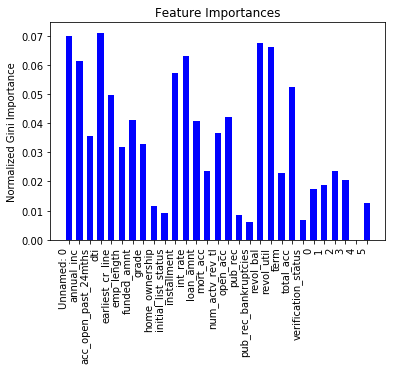

In [463]:
'''
Feauture importance
'''
fig, ax = plt.subplots()
width = 0.6
feature_importances = pd.DataFrame(random_forest_classifier.feature_importances_, index = dataset.columns, columns = ['Importance']).sort_values('Importance', ascending = False)
print(feature_importances)
ax.bar(np.arange(len(dataset.columns)), random_forest_classifier.feature_importances_, width, color='b')
ax.set_xticks(np.arange(len(random_forest_classifier.feature_importances_)))
ax.set_xticklabels(dataset.columns.values, rotation = 90, horizontalalignment='right')
plt.title('Feature Importances')
ax.set_ylabel('Normalized Gini Importance')

In [464]:
'''
Multi-layer perceptron
'''
multi_layer_perceptron_classifier = MLPClassifier(solver='lbfgs', alpha = 1e-5, hidden_layer_sizes = (5, 2), random_state = 1)
multi_layer_perceptron_classifier.fit(X_train, y_train)     
mlp_y_pred = multi_layer_perceptron_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
print("Test Accuracy: ", (mlp_accuracy  * 100.0))
print("Confusion Matrix: ", confusion_matrix(y_test, mlp_y_pred, labels=[0, 1]))
print(classification_report(y_test, mlp_y_pred))

Test Accuracy:  81.80914088382622
Confusion Matrix:  [[132001   1631]
 [ 28184   2085]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    133632
           1       0.56      0.07      0.12     30269

   micro avg       0.82      0.82      0.82    163901
   macro avg       0.69      0.53      0.51    163901
weighted avg       0.78      0.82      0.76    163901



In [465]:
'''
Multi-layer perceptron with Adam solver + changed hyperparams
'''
multi_layer_perceptron_classifier_2 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum = True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08,n_iter_no_change = 10)
multi_layer_perceptron_classifier_2.fit(X_train, y_train)     
mlp_y_pred_2 = multi_layer_perceptron_classifier.predict(X_test)
mlp_accuracy_2 = accuracy_score(y_test, mlp_y_pred_2)
print("Test Accuracy: ", (mlp_accuracy_2 * 100.0))
print("Confusion Matrix: ", confusion_matrix(y_test, mlp_y_pred_2, labels=[0, 1]))
print(classification_report(y_test, mlp_y_pred_2))

Test Accuracy:  81.80914088382622
Confusion Matrix:  [[132001   1631]
 [ 28184   2085]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    133632
           1       0.56      0.07      0.12     30269

   micro avg       0.82      0.82      0.82    163901
   macro avg       0.69      0.53      0.51    163901
weighted avg       0.78      0.82      0.76    163901



In [466]:
'''
Xgb Boost
'''
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred_3 = model.predict(X_test)
predictions = [round(value) for value in y_pred_3]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print(" Test Accuracy: %.2f%%" % (accuracy * 100.0))
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_3, labels=[0, 1]))
print(classification_report(y_test, y_pred_3))

 Test Accuracy: 81.93%
Confusion Matrix:  [[131909   1723]
 [ 27898   2371]]
              precision    recall  f1-score   support

           0       0.83      0.99      0.90    133632
           1       0.58      0.08      0.14     30269

   micro avg       0.82      0.82      0.82    163901
   macro avg       0.70      0.53      0.52    163901
weighted avg       0.78      0.82      0.76    163901



In [467]:
'''Light GBM Boost'''
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'rf'
params['objective'] = 'binary'
params['bagging_freq'] = 1
params['bagging_fraction'] = 0.9
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 200
params['min_data'] = 50
params['max_depth'] = 20
clf = lgb.train(params, d_train, 200)
y_pred_train = clf.predict(X_train)
train_predictions = [round(value) for value in y_pred_train]
print("Train accurracy: {}".format(accuracy_score(y_train, train_predictions)))
y_pred_4 = clf.predict(X_test)
predictions = [round(value) for value in y_pred_4]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print(" Test Accuracy: %.2f%%" % (accuracy * 100.0))
# print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_4, labels=[0, 1]))
# print(classification_report(y_test, y_pred_4))


Train accurracy: 0.8211531421598536
 Test Accuracy: 81.85%


In [468]:
print("Confusion Matrix: ", confusion_matrix(y_test, predictions, labels=[0, 1]))
print(classification_report(y_test, predictions))

Confusion Matrix:  [[130713   2919]
 [ 26821   3448]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90    133632
           1       0.54      0.11      0.19     30269

   micro avg       0.82      0.82      0.82    163901
   macro avg       0.69      0.55      0.54    163901
weighted avg       0.78      0.82      0.77    163901

